In [1]:
import pandas as pd
from functools import reduce

from analysis_modules import compute_accuracy, add_accuracy_diff, plot, plot_metrics, analyze_errors, balance_df

In [24]:
# code used to create the data splits

# merging the proposals set with the different subsets (train, valid, test)
# CFS = pd.read_csv('../data/CoFE/CFS_without_debates_CFET.tsv', sep='\t')
# proposals = pd.read_csv('../data/CoFE/prop_CF_all.tsv', sep='\t')
# CoFE_train = pd.merge(proposals, CFS.drop('Topic', axis=1), left_on='id', right_on='id_prop', suffixes=('_prop', '_cm'))
# CoFE_train = CoFE_train.loc[:, ~CoFE_train.columns.duplicated()]
# CoFE_train.to_csv('../data/CoFE/CoFE_train.csv', index=None)

# keeping only samples where both the target and the comment are in either German, French or English (train set only)
# (to avoid balancing with rare languages and dropping too much data)
# CoFE_train_filtered = CoFE_train[CoFE_train['lan_prop'].isin(['de', 'fr', 'en']) & CoFE_train['lan_cm'].isin(['de', 'fr', 'en'])]

# adding a label column that is exactly the same as the alignment column for consistency during training (train set only)
# CoFE_train_filtered['label'] = CoFE_train_filtered['alignment']
# CoFE_train_filtered.to_csv('../data/CoFE/CoFE_train_filtered.csv', index=None)

# dropping the 'Other' label for consistency with the train set (validation and test sets)
# valid = pd.read_csv('../data/CoFE/CoFE_valid.csv')
# valid_filtered = valid[~(valid['label'] == 'Other')]
# valid_filtered.to_csv('../data/CoFE/CoFE_valid_filtered.csv', index=None)
# test = pd.read_csv('../data/CoFE/CoFE_test.csv')
# test_filtered = test[~(test['label'] == 'Other')]
# test_filtered.to_csv('../data/CoFE/CoFE_test_filtered.csv', index=None)

In [4]:
# balance_df(pd.read_csv('../data/CoFE/CoFE_train_filtered.csv'), columns=['lan_cm', 'label'])

In [19]:
# import pickle

# label_map = {'In favor': 0, 'Against': 1, 'Other': 2}

# with open('../models/cofe_label_map.pickle', 'wb') as f:  
#     pickle.dump(label_map, f)

# with open('../models/cofe_label_map.pickle', 'rb') as file:
#     label_mapping = pickle.load(file)

# label_mapping

{'In favor': 0, 'Against': 1, 'Other': 2}

---

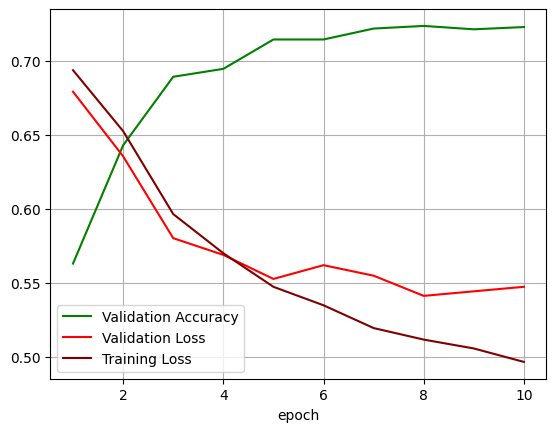

In [2]:
model_dir = "../models/xlmr+xstance_lora"
plot_metrics(model_dir)

### Performance of fine-tuning using LoRA

In [4]:
xlmr_xstance_lora_preds = pd.read_csv('../predictions/xlmr+xstance_lora_preds.csv')
xlmr_xstance_lora_acc = compute_accuracy(xlmr_xstance_lora_preds, 'label', 'prediction')

In [5]:
xlmr_xstance_cofe_lora_preds = pd.read_csv('../predictions/xlmr+xstance+cofe_lora_preds.csv')
xlmr_xstance_cofe_lora_acc = compute_accuracy(xlmr_xstance_cofe_lora_preds, 'label', 'prediction')

In [6]:
# All accuracies combined

all_acc = reduce(lambda left, right: pd.merge(left, right, on='language'), [
    vanilla_xlmr_acc.rename(columns={'accuracy': 'acc_xlmr'}),
    xlmr_xstance_lora_acc.rename(columns={'accuracy': 'acc_xlmr+xstance (LoRA)'}),
    xlmr_xstance_cofe_lora_acc.rename(columns={'accuracy': 'acc_xlmr+xstance+cofe (LoRA)'})
])
all_acc

,language,acc_xlmr,acc_xlmr+xstance (LoRA),acc_xlmr+xstance+cofe (LoRA)
0,de,0.494660,0.690943,0.597427
1,fr,0.456502,0.741529,0.648810
2,it,0.460581,0.725450,0.638313


In [7]:
merged_lora_preds = pd.merge(xlmr_xstance_cofe_lora_preds, xlmr_xstance_lora_preds[['id', 'prediction']].rename(columns={'prediction': 'xstance_preds'}), on='id')
cofe_xstance_acc_wrt_xstance = compute_accuracy(merged_lora_preds, 'xstance_preds', 'prediction')
cofe_xstance_acc_wrt_xstance

,language,accuracy
0,de,0.744008
1,fr,0.772207
2,it,0.742739


### Performance of fine-tuning without LoRA (predictions on the X-Stance test set)

In [2]:
test = pd.read_json('../data/xstance/test.jsonl', lines=True)
baseline_acc = compute_accuracy(test, 'label', group_by='language', baseline=True)

In [4]:
xlmr_xstance_preds = pd.read_csv('../predictions/on_xstance_test/xlmr+xstance_preds.csv')
xlmr_xstance_acc = compute_accuracy(xlmr_xstance_preds, 'label', 'prediction')

In [5]:
xlmr_xstance_cofe_preds = pd.read_csv('../predictions/on_xstance_test/xlmr+xstance+cofe_preds.csv')
xlmr_xstance_cofe_acc = compute_accuracy(xlmr_xstance_cofe_preds, 'label', 'prediction')

In [7]:
# All accuracies combined

all_acc = reduce(lambda left, right: pd.merge(left, right, on='language'), [
    baseline_acc.rename(columns={'accuracy': 'baseline(MFC)'}),
    xlmr_xstance_acc.rename(columns={'accuracy': 'acc_xlmr+xstance'}),
    xlmr_xstance_cofe_acc.rename(columns={'accuracy': 'acc_xlmr+xstance+cofe'})
])

add_accuracy_diff(all_acc, 'baseline(MFC)')

,language,baseline(MFC),acc_xlmr+xstance,acc_xlmr+xstance+cofe
0,de,0.51,0.72 (+0.21),0.63 (+0.12)
1,fr,0.54,0.77 (+0.23),0.65 (+0.11)
2,it,0.54,0.74 (+0.20),0.61 (+0.07)


In [8]:
add_accuracy_diff(all_acc, 'acc_xlmr+xstance')

,language,baseline(MFC),acc_xlmr+xstance,acc_xlmr+xstance+cofe
0,de,0.51 (-0.21),0.72,0.63 (-0.09)
1,fr,0.54 (-0.23),0.77,0.65 (-0.12)
2,it,0.54 (-0.20),0.74,0.61 (-0.13)


### Performance of fine-tuning without LoRA (predictions on the CoFE test set)

In [9]:
test = pd.read_csv('../data/CoFE/CoFE_test_filtered.csv')
baseline_acc = compute_accuracy(test, 'label', group_by='lan_cm', baseline=True)

In [10]:
xlmr_xstance_preds = pd.read_csv('../predictions/on_cofe_test/xlmr+xstance_preds.csv')
xlmr_xstance_acc = compute_accuracy(xlmr_xstance_preds, 'label', 'prediction', group_by='lan_cm')

In [11]:
xlmr_xstance_cofe_preds = pd.read_csv('../predictions/on_cofe_test/xlmr+xstance+cofe_preds.csv')
xlmr_xstance_cofe_acc = compute_accuracy(xlmr_xstance_cofe_preds, 'label', 'prediction', group_by='lan_cm')

In [12]:
# All accuracies combined

all_acc = reduce(lambda left, right: pd.merge(left, right, on='lan_cm'), [
    baseline_acc.rename(columns={'accuracy': 'baseline(MFC)'}),
    xlmr_xstance_acc.rename(columns={'accuracy': 'acc_xlmr+xstance'}),
    xlmr_xstance_cofe_acc.rename(columns={'accuracy': 'acc_xlmr+xstance+cofe'})
])

add_accuracy_diff(all_acc, 'baseline(MFC)')

,lan_cm,baseline(MFC),acc_xlmr+xstance,acc_xlmr+xstance+cofe
0,de,0.73,0.80 (+0.07),0.83 (+0.10)
1,el,0.65,0.82 (+0.17),0.82 (+0.17)
2,en,0.75,0.84 (+0.09),0.86 (+0.11)
3,fr,0.75,0.76 (+0.01),0.80 (+0.05)
4,hu,0.83,0.86 (+0.03),0.91 (+0.08)
5,it,0.87,0.80 (-0.07),0.84 (-0.03)


In [13]:
add_accuracy_diff(all_acc, 'acc_xlmr+xstance')

,lan_cm,baseline(MFC),acc_xlmr+xstance,acc_xlmr+xstance+cofe
0,de,0.73 (-0.07),0.80,0.83 (+0.03)
1,el,0.65 (-0.17),0.82,0.82 (+0.00)
2,en,0.75 (-0.09),0.84,0.86 (+0.02)
3,fr,0.75 (-0.01),0.76,0.80 (+0.04)
4,hu,0.83 (-0.03),0.86,0.91 (+0.05)
5,it,0.87 (+0.07),0.80,0.84 (+0.04)
